In [1]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

**NONSTATIONARY**

In [2]:
# nonstationary data 
input_data = np.load('data/input_sal_temp_ns.npy')
output_data = np.load('data/output_sal_temp_ns.npy')

In [3]:
Sv=1e9

In [4]:
X_train = input_data[0:60000]
y_train = output_data[0:60000]
X_val = input_data[60000:80000]
y_val = output_data[60000:80000]
X_test = input_data[80000:100000]
y_test = output_data[80000:100000] 

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

Y_train = keras.utils.to_categorical(y_train)
Y_val = keras.utils.to_categorical(y_val)
Y_test = keras.utils.to_categorical(y_test)

In [6]:
# defining the MLP
model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# Train the model on the training set and validate on the validation set
model_eval = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2515 - accuracy: 0.9707 - val_loss: 0.1312 - val_accuracy: 0.9996
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0697 - accuracy: 0.9995 - val_loss: 0.0500 - val_accuracy: 0.9987
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0278 - accuracy: 0.9998 - val_loss: 0.0220 - val_accuracy: 0.9990
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0123 - accuracy: 0.9998 - val_loss: 0.0115 - val_accuracy: 0.9990
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0058 - accuracy: 0.9998 - val_loss: 0.0048 - val_accuracy: 0.9996
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.0028 - val_accuracy: 0.9996
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0032 - val_accuracy:

In [8]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

625/625 [==============================] - 0s 710us/step - loss: 0.0015 - accuracy: 0.9996
Test loss: 0.0014803000958636403
Test accuracy: 0.9995999932289124


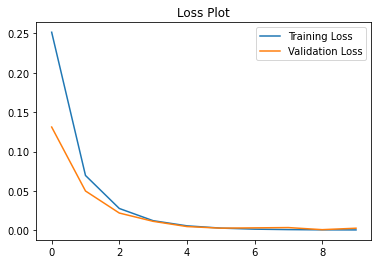

In [9]:
plt.plot(model_eval.history['loss'], label='Training Loss');
plt.plot(model_eval.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot');
plt.legend();

In [10]:
y_pred_all = model.predict(input_scaled)

3125/3125 [==============================] - 2s 636us/step


In [11]:
threshold = 0.5
predictions = (model.predict(input_scaled) > threshold).astype(int)  # Convert probabilities to 0 or 1

3125/3125 [==============================] - 2s 652us/step


In [13]:
false_indices_sal_temp_sine = []
for i in range(len(predictions)):
    if predictions[i] != output_data[i]:
        false_indices_sal_temp_sine.append(i)

In [9]:
qplot = np.load('data/q_sal_temp_ns.npy')

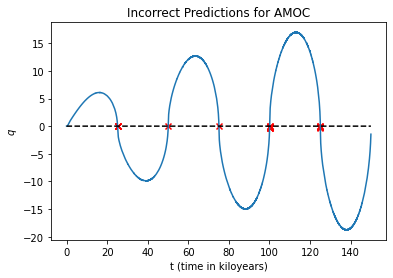

In [15]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC');
plt.scatter([input_data[:, 0][i] for i in false_indices_sal_temp_sine], [qplot[i]/Sv for i in false_indices_sal_temp_sine], marker='x', c='red');

In [16]:
training_losses = np.zeros(10, dtype=np.ndarray)
validation_losses = np.zeros(10, dtype=np.ndarray)

In [17]:
# training the ensemble 
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model_eval = model.fit(X_train_scaled, y_train,
                    batch_size=8,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[es])#,
    training_losses[i] = model_eval.history['loss']
    validation_losses[i] = model_eval.history['val_loss']
    os.makedirs("models_mlp_ns", exist_ok=True)
    model.save('models_mlp_ns/ensemble_member_'+str(i)+'.keras')

0
1
2
3
Epoch 7: early stopping
4
5
6
7
Epoch 8: early stopping
8
9


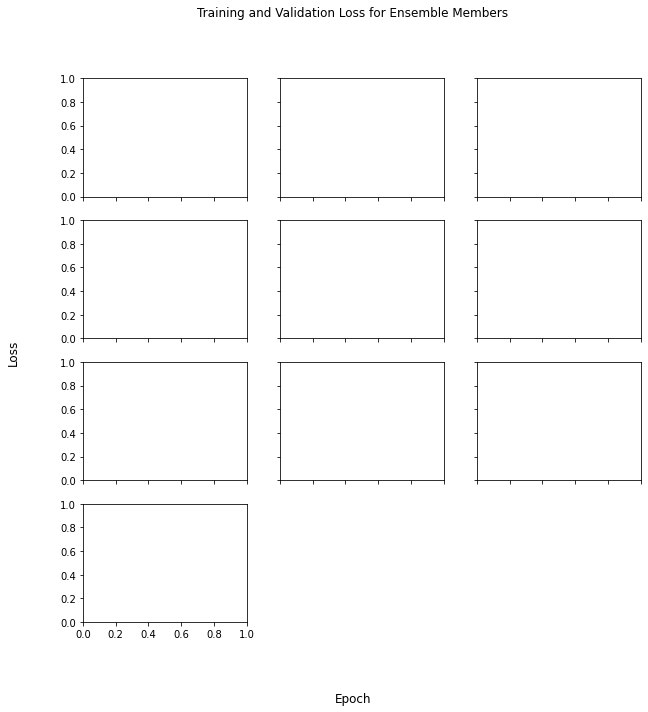

In [18]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10));
fig.supxlabel('Epoch');
fig.supylabel('Loss');
fig.suptitle('Training and Validation Loss for Ensemble Members');
ax = ax.flatten();
for j in range(10, 12):  # 2 extra subplots in the 4x3 grid
    ax[j].axis('off');

In [19]:
for i in range(10):
    ax[i].plot(training_losses[i], label='Training Loss')
    ax[i].plot(validation_losses[i], label='Validation Loss')
    ax[i].set_title('Ensemble Member #' + str(i))

In [20]:
fig.legend(
    labels=['Training Loss', 'Validation Loss'],
    loc='lower right',
    bbox_to_anchor=(0.9, 0.2)  # fine-tune if needed
)

In [21]:
fig.savefig('figures/mlp_losses_nonstationary', dpi=100)

In [22]:
accuracies = []

In [23]:
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.load_weights('models_mlp_ns/ensemble_member_'+str(i)+'.keras')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_scaled, y_test)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

0
625/625 [==============================] - 1s 761us/step - loss: 0.0041 - accuracy: 0.9995
Test loss: 0.004051839467138052
Test accuracy: 0.9994999766349792
1
625/625 [==============================] - 1s 795us/step - loss: 8.4397e-04 - accuracy: 0.9998
Test loss: 0.0008439739467576146
Test accuracy: 0.999750018119812
2
625/625 [==============================] - 1s 862us/step - loss: 0.0016 - accuracy: 0.9996
Test loss: 0.0015750270104035735
Test accuracy: 0.9995999932289124
3
625/625 [==============================] - 1s 867us/step - loss: 0.0014 - accuracy: 0.9997
Test loss: 0.001365224365144968
Test accuracy: 0.9996500015258789
4
625/625 [==============================] - 1s 822us/step - loss: 0.0011 - accuracy: 0.9996
Test loss: 0.0010591703467071056
Test accuracy: 0.9995999932289124
5
625/625 [==============================] - 1s 849us/step - loss: 0.0027 - accuracy: 0.9995
Test loss: 0.0027081556618213654
Test accuracy: 0.9995499849319458
6
625/625 [============================

In [24]:
sum(accuracies)/10*100

99.95999991893768

In [7]:
predicted_results_ensemble = np.nan * np.zeros((10, input_scaled.shape[0], 1))

for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.load_weights('models_mlp_ns/ensemble_member_'+str(i)+'.keras')
    predicted = model.predict(input_scaled)
    predicted_results_ensemble[i,...] = predicted

0
3125/3125 [==============================] - 2s 664us/step
1
3125/3125 [==============================] - 2s 585us/step
2
3125/3125 [==============================] - 2s 645us/step
3
3125/3125 [==============================] - 2s 632us/step
4
3125/3125 [==============================] - 2s 658us/step
5
3125/3125 [==============================] - 2s 657us/step
6
3125/3125 [==============================] - 2s 658us/step
7
3125/3125 [==============================] - 2s 704us/step
8
3125/3125 [==============================] - 2s 624us/step
9
3125/3125 [==============================] - 2s 603us/step


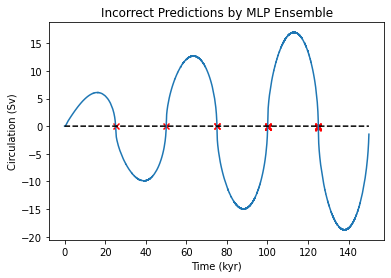

In [11]:
avg_predicted = np.mean(predicted_results_ensemble, axis=0).reshape(100000)
threshold = 0.5
avg_pred = (avg_predicted > threshold).astype(int)
false_indices = []
for j in range(len(avg_pred)):
    if avg_pred[j] != output_data[j]:
        false_indices.append(j)
fig, ax = plt.subplots()
ax.plot(input_data[:, 0], qplot/Sv);
ax.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
ax.set_title('Incorrect Predictions by MLP Ensemble');
ax.scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
ax.set_xlabel('Time (kyr)');
ax.set_ylabel('Circulation (Sv)');
fig.savefig('figures/mlp_predictions_ns_all', dpi=100)

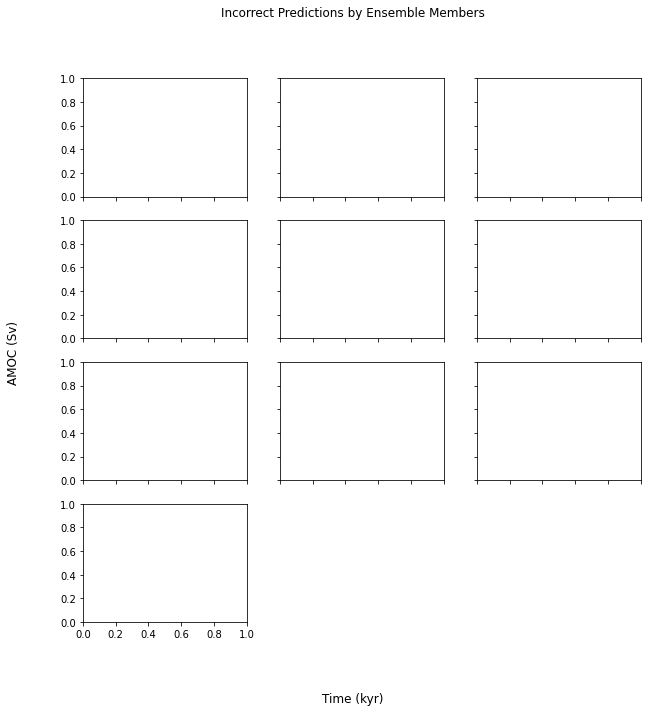

In [26]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Incorrect Predictions by Ensemble Members')
ax = ax.flatten()
for j in range(10, 12):  # 2 extra subplots in the 4x3 grid
    ax[j].axis('off')

In [27]:
for i in range(10):
    ensemble_i_pred = (predicted_results_ensemble[i] > threshold).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_data[j]:
            false_indices.append(j)
    ax[i].plot(input_data[:, 0], qplot/Sv);
    ax[i].plot(input_data[:, 0], input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member #' + str(i));
    ax[i].scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');

In [28]:
import matplotlib.lines as mlines
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Incorrect Prediction')

# Global legend in lower right

fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.2))

In [29]:
fig.savefig('figures/mlp_predictions_nonstationary', dpi=100)